In [2]:
!pip install transformers
!pip install joblib
import re
import nltk
import torch
import string
import requests
import numpy as np
import pandas as pd
from io import StringIO
import multiprocessing as mp
from tabulate import tabulate
from textblob import TextBlob
from google.colab import files
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from collections import defaultdict
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer, WordNetLemmatizer

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stemmer = SnowballStemmer('english')
lemmatizer = WordNetLemmatizer()
plt.style.use('fivethirtyeight')
pd.set_option('display.float_format', '{:.4f}'.format)
stop_words = set(stopwords.words('english'))
model_path = "cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
# import data

df = pd.read_csv("chatgpt-tweets-data-20230310-20230322.csv")
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0


# Data Preprocessing

In [ ]:
# remove @mentions, tags, retweets, hyper link, non-ASCII characters, punctuation
   
def clean_text(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'RT[\s]+', '', text)
    text = re.sub(r'https?:\/\/S+', '', text)
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = text.translate(str.maketrans(string.punctuation, ' ' * len(string.punctuation)))
    tokens = word_tokenize(text)
    stemmed_tokens = [stemmer.stem(token) for token in tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in stemmed_tokens]
    clean_text = ' '.join(lemmatized_tokens)
    return clean_text

df['cleanTweet'] = df['Tweet'].apply(clean_text)
df['cleanTweet'] = df['cleanTweet'].str.lower()
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,cleanTweet
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,chatgpt is anoth woke machin
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,of the atlant or onli near the atla more to me...
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,this thread is save to your notion databas tag...
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,prompt ai chatgpt
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,just had some interest convers with googl s ba...


## Get Time information

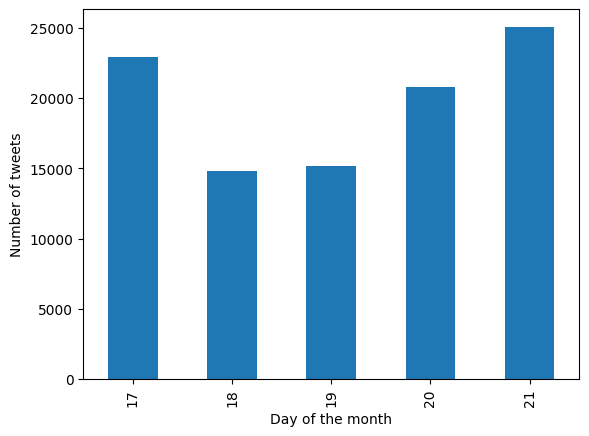

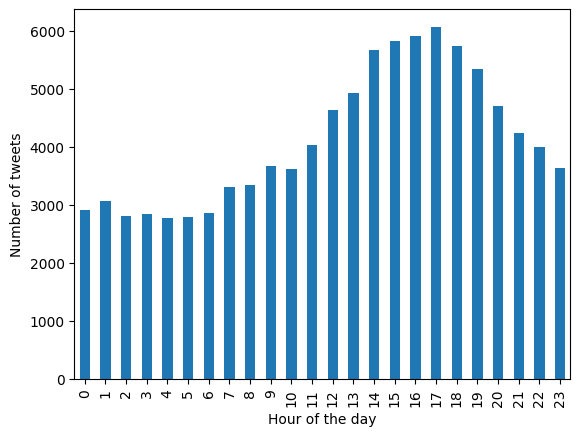

In [ ]:
# extract time information
df['Date'] = pd.to_datetime(df['Date'])
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['day'] = df['Date'].dt.day
df['hour'] = df['Date'].dt.hour

# plot the distribution of tweets by day
df.groupby('day').size().plot(kind='bar')
plt.xlabel('Day of the month')
plt.ylabel('Number of tweets')
plt.show()

# plot the distribution of tweets by hour
df.groupby('hour').size().plot(kind='bar')
plt.xlabel('Hour of the day')
plt.ylabel('Number of tweets')
plt.show()

## Get words with the most frequencies and draw the word cloud

In [ ]:
# count word frequency (not including stop words)
words_frequency_dict = defaultdict(int)
for tweet in df['cleanTweet']:
  for word in tweet.split():
    if word not in stop_words:
      words_frequency_dict[word] += 1
words_frequency = sorted(words_frequency_dict.items(), key=lambda x: x[1], reverse = True)

print(tabulate(words_frequency[:10], headers=['Word', 'Frequency']))

Word       Frequency
-------  -----------
chatgpt        71445
use            16249
ai             15622
gpt            15526
chat           12927
like            8927
ask             8557
4               8281
write           6504
wa              6237


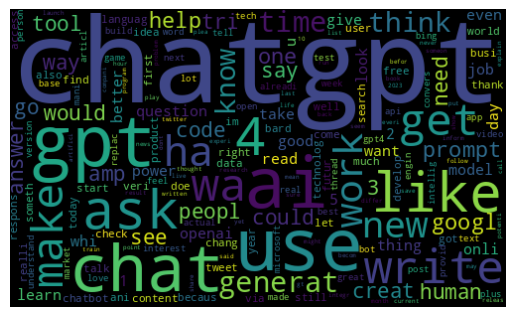

In [ ]:
# plot the word cloud

words = [wf[0] for wf in words_frequency]
wordCloud = WordCloud(width=500, height=300, random_state=25, max_font_size=120)
wordCloud.generate_from_frequencies(words_frequency_dict)

plt.imshow(wordCloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

# Method 1: Compute Polarity and Subjectivity based on TextBlob, and get sentiment results (polarity smaller/equal/larger than 0)

In [ ]:
# subjectivity and polarity

def get_subjectivity(text):
  return TextBlob(text).sentiment.subjectivity

def get_polarity(text):
  return TextBlob(text).sentiment.polarity

df['Subjectivity'] = df['cleanTweet'].apply(get_subjectivity)
df['Polarity'] = df['cleanTweet'].apply(get_polarity)
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,cleanTweet,year,month,day,hour,Subjectivity,Polarity
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,chatgpt is anoth woke machin,2023,3,21,23,0.0000,0.0000
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,of the atlant or onli near the atla more to me...,2023,3,21,23,0.4000,0.1333
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,this thread is save to your notion databas tag...,2023,3,21,23,0.0000,0.0000
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,prompt ai chatgpt,2023,3,21,23,0.0000,0.0000
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,just had some interest convers with googl s ba...,2023,3,21,23,0.5000,0.5000


In [ ]:
df['SentimentResult1'] = df['Polarity'].apply(lambda x: 'Positive' if x > 0.0 else ('Negative' if x < 0.0 else 'Neutral'))
df.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,cleanTweet,year,month,day,hour,Subjectivity,Polarity,SentimentResult1
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,chatgpt is anoth woke machin,2023,3,21,23,0.0000,0.0000,Neutral
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #推特账号 m...",0,0,0,0,of the atlant or onli near the atla more to me...,2023,3,21,23,0.4000,0.1333,Positive
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,this thread is save to your notion databas tag...,2023,3,21,23,0.0000,0.0000,Neutral
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI – ChatGPT #0018,1,0,0,0,prompt ai chatgpt,2023,3,21,23,0.0000,0.0000,Neutral
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,just had some interest convers with googl s ba...,2023,3,21,23,0.5000,0.5000,Positive


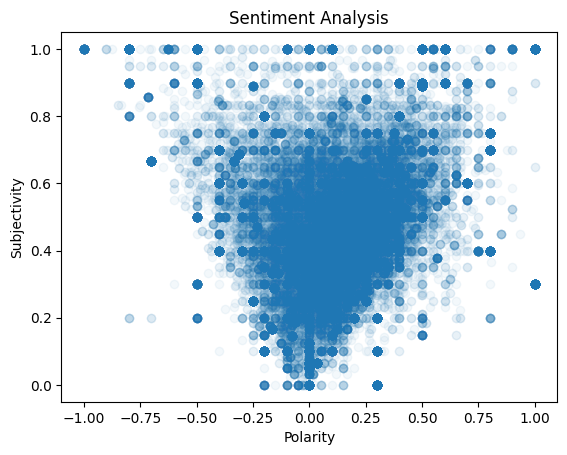

In [ ]:
# plot polarity vs subjectivity

plt.scatter(df['Polarity'], df['Subjectivity'], alpha=0.05)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

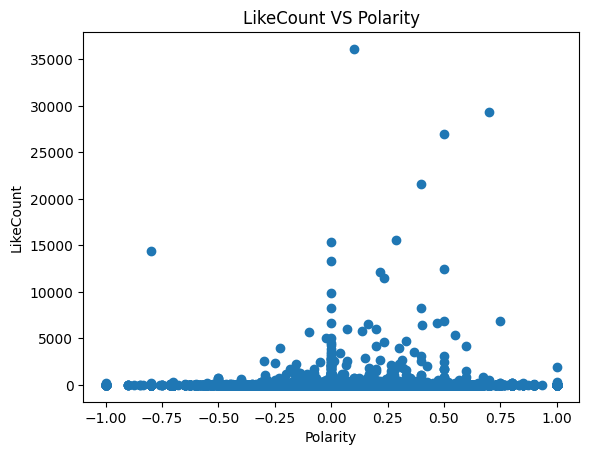

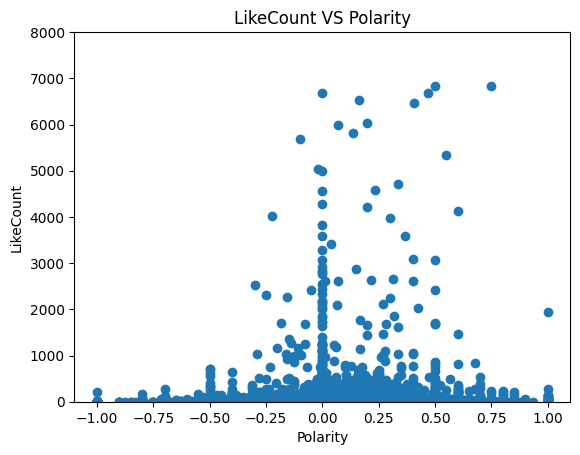

In [ ]:
# plot polarity vs LikeCount

plt.scatter(df['Polarity'], df['LikeCount'])
plt.title('LikeCount VS Polarity')
plt.xlabel('Polarity')
plt.ylabel('LikeCount')
plt.show()

plt.scatter(df['Polarity'], df['LikeCount'])
plt.title('LikeCount VS Polarity')
plt.xlabel('Polarity')
plt.ylabel('LikeCount')
plt.ylim(0, 8000)
plt.show()

# Method 2: Get Sentiment Result based on the roBERTa-base model (trained on ~58M tweets)

## Since it takes totally 5 hours to run the whole process, we load the result from the final csv file

In [3]:
# Get the sentiment result which has the highest predicted probability

# df_subset = df.iloc[:, :]
def get_roberta_sentiment_score(text):
    tokens = tokenizer.encode(text, add_special_tokens=True)
    output = roberta_model(torch.tensor([tokens]))[0]
    predicted_label = torch.argmax(output).item()
    
    if predicted_label == 0:
      return 'Negative'
    elif predicted_label == 1:
      return 'Neutral'
    else: #2
      return 'Positive'

# # Define the function for applying the sentiment analysis in parallel
# def apply_parallel(chunk):
#     return chunk.apply(get_roberta_sentiment_score)

# # Split the dataset into chunks for parallel processing
# n = mp.cpu_count()
# chunks = np.array_split(df_subset['cleanTweet'], n)

# # Create a pool of worker processes
# pool = mp.Pool(processes=n)

# # Apply the function to each chunk in parallel
# results = pool.map(apply_parallel, chunks)

# # Close the pool of worker processes
# pool.close()

# # Concatenate the results from each chunk into a single dataframe
# result_df = pd.concat(results)

# # Add the results to the original dataframe
# df_subset['SentimentResult2'] = result_df.values


# df_with_robert = pd.read_csv("df_with_robert.csv") 

df_with_robert_csv_dwn_url = 'https://drive.google.com/uc?id=1AlWBehf_CJPhEhRxArWWFw-7O8cu0YFv'
response2 = requests.get(df_with_robert_csv_dwn_url)
df_with_robert = pd.read_csv(StringIO(response2.text))
df_with_robert.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,cleanTweet,year,month,day,hour,Subjectivity,Polarity,SentimentResult1,SentimentResult2
0,1638329623946878976,2023-03-21 23:59:55+00:00,lqgds36373,ChatGPT is another woke machine.,4,4,32,0,chatgpt is anoth woke machin,2023,3,21,23,0.0000,0.0000,Neutral,Neutral
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #æ¨ç¹...",0,0,0,0,of the atlant or onli near the atla more to me...,2023,3,21,23,0.4000,0.1333,Positive,Neutral
2,1638329600471171074,2023-03-21 23:59:50+00:00,cwsea23772,This thread is saved to your Notion database....,0,0,0,0,this thread is save to your notion databas tag...,2023,3,21,23,0.0000,0.0000,Neutral,Neutral
3,1638329587133194240,2023-03-21 23:59:46+00:00,jerje51666,Prompt AI â ChatGPTÂ #0018,1,0,0,0,prompt ai chatgpt,2023,3,21,23,0.0000,0.0000,Neutral,Neutral
4,1638329567759802368,2023-03-21 23:59:42+00:00,wwxly15746,Just had some interesting conversations with G...,1,0,0,0,just had some interest convers with googl s ba...,2023,3,21,23,0.5000,0.5000,Positive,Positive


# Compare sentiment results of two methods

---



TextBlob vs roberta

In [ ]:
df_sentiment_result_diff = df_with_robert[df_with_robert['SentimentResult1'] != df_with_robert['SentimentResult2']]
len(df_sentiment_result_diff)

47360

In [ ]:
df_diff_50 = df_sentiment_result_diff.iloc[:50,:]

# Download the first 50 differences
# df_diff_50.to_csv('df_diff_50.csv', index=False)
# files.download('df_diff_50.csv')

df_diff_50.head()

,ID,Date,Username,Tweet,ReplyCount,RetweetCount,LikeCount,QuoteCount,cleanTweet,year,month,day,hour,Subjectivity,Polarity,SentimentResult1,SentimentResult2
1,1638329621581275136,2023-03-21 23:59:55+00:00,yxwec12342,"of the Atlantic, or only near the Atla #æ¨ç¹...",0,0,0,0,of the atlant or onli near the atla more to me...,2023,3,21,23,0.4000,0.1333,Positive,Neutral
5,1638329564312264704,2023-03-21 23:59:41+00:00,xfcfc69355,Copilot has actually been useful for me thoug...,0,0,2,0,copilot ha actual been use for me though it ro...,2023,3,21,23,0.1000,0.0000,Neutral,Negative
6,1638329556074475521,2023-03-21 23:59:39+00:00,cjxpg99081,i had chatgpt analyze my ocs after askin a bun...,2,0,0,0,i had chatgpt analyz my oc after askin a bunch...,2023,3,21,23,0.2000,0.3000,Positive,Negative
7,1638329552861556740,2023-03-21 23:59:38+00:00,kkcju69991,You are a smart guy Mark. You should be able...,0,0,0,0,you are a smart guy mark you should be abl to ...,2023,3,21,23,0.3839,0.1071,Positive,Neutral
11,1638329474629640195,2023-03-21 23:59:20+00:00,vyuxa61547,"Thanks to ChatGPT, we are one step closer to g...",0,1,0,0,thank to chatgpt we are one step closer to get...,2023,3,21,23,0.0000,0.0000,Neutral,Positive


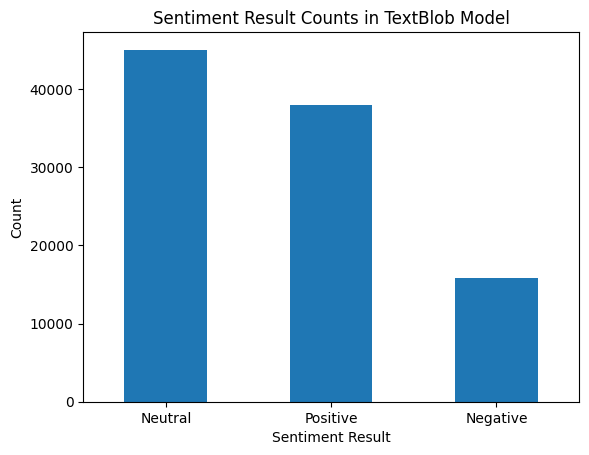

In [ ]:
plt.style.use('default')
sentiment_counts = df_with_robert['SentimentResult1'].value_counts()
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Result Counts in TextBlob Model')
plt.xlabel('Sentiment Result')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

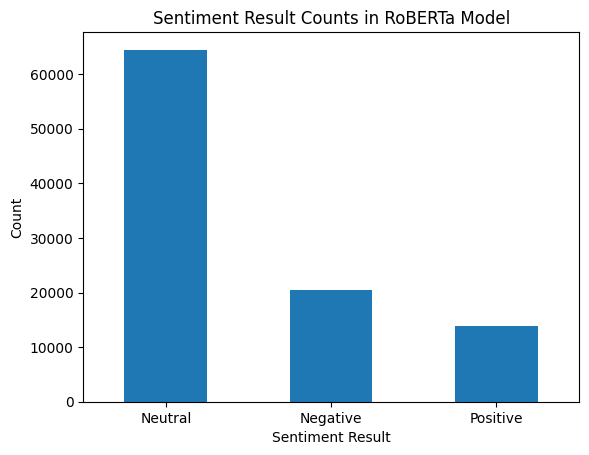

In [ ]:
sentiment_counts = df_with_robert['SentimentResult2'].value_counts()
sentiment_counts.plot(kind='bar')
plt.title('Sentiment Result Counts in RoBERTa Model')
plt.xlabel('Sentiment Result')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

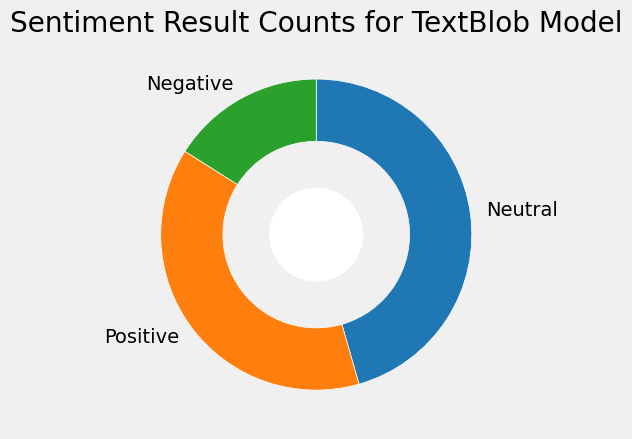

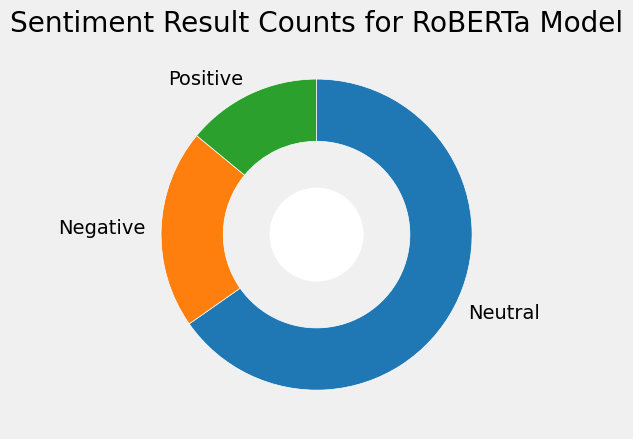

In [ ]:

sentiment_counts_1 = df_with_robert['SentimentResult1'].value_counts()
percentages_1 = sentiment_counts_1 / sentiment_counts_1.sum() * 100

sentiment_counts_2 = df_with_robert['SentimentResult2'].value_counts()
percentages_2 = sentiment_counts_2 / sentiment_counts_2.sum() * 100

angles = np.linspace(0, 2*np.pi, len(sentiment_counts_1)+1)

fig, ax = plt.subplots()
ax.pie(percentages_1, labels=percentages_1.index, startangle=90, counterclock=False,
       radius=1, wedgeprops={'width': 0.4, 'edgecolor': 'white'}, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
circle = plt.Circle((0,0), 0.3, color='white')
ax.add_artist(circle)
plt.title('Sentiment Result Counts for TextBlob Model')
plt.show()

fig, ax = plt.subplots()
ax.pie(percentages_2, labels=percentages_2.index, startangle=90, counterclock=False,
       radius=1, wedgeprops={'width': 0.4, 'edgecolor': 'white'}, colors=['#1f77b4', '#ff7f0e', '#2ca02c'])
circle = plt.Circle((0,0), 0.3, color='white')
ax.add_artist(circle)
plt.title('Sentiment Result Counts for RoBERTa Model')
plt.show()


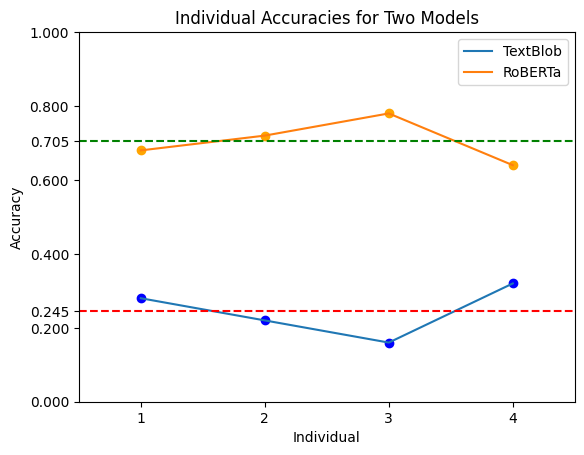

In [ ]:
plt.style.use('default')
humanresult = pd.read_csv('humanresult.csv')
accuracy1_1 = (humanresult['label1'] == humanresult['SentimentResult1']).mean()
accuracy1_2 = (humanresult['label1'] == humanresult['SentimentResult2']).mean()

accuracy2_1 = (humanresult['label2'] == humanresult['SentimentResult1']).mean()
accuracy2_2 = (humanresult['label2'] == humanresult['SentimentResult2']).mean()

accuracy3_1 = (humanresult['label3'] == humanresult['SentimentResult1']).mean()
accuracy3_2 = (humanresult['label3'] == humanresult['SentimentResult2']).mean()

accuracy4_1 = (humanresult['label4'] == humanresult['SentimentResult1']).mean()
accuracy4_2 = (humanresult['label4'] == humanresult['SentimentResult2']).mean()

import matplotlib.pyplot as plt
import numpy as np

# create sample data
model1_acc = [accuracy1_1, accuracy2_1, accuracy3_1, accuracy4_1]  # accuracies of four people on model 1
model2_acc = [accuracy1_2, accuracy2_2, accuracy3_2, accuracy4_2]  # accuracies of four people on model 2

# calculate mean accuracies
mean_model1_acc = np.mean(model1_acc)
mean_model2_acc = np.mean(model2_acc)

# create a line plot of the individual accuracies
x = np.array([1, 2, 3, 4])
fig, ax = plt.subplots()
plt.plot(x, model1_acc,  label='TextBlob')
plt.plot(x, model2_acc,  label='RoBERTa')
plt.xlabel('Individual')
plt.ylabel('Accuracy')
plt.title('Individual Accuracies for Two Models')
plt.legend()

# add scatter plot of individual accuracies

plt.scatter(x, model1_acc, color='b')
plt.scatter(x, model2_acc, color='orange')

# add horizontal lines for the mean accuracies
plt.axhline(mean_model1_acc, color='r', linestyle='--')
plt.axhline(mean_model2_acc, color='g', linestyle='--')

# adjust x and y ranges
plt.xlim([0.5, 4.5])
plt.ylim([0, 1])
ax.set_yticks([0.0, 0.2, 0.245, 0.4, 0.6, 0.705, 0.8, 1.0])
plt.xticks(range(1, 5), range(1, 5))
# display the chart
plt.show()

In [ ]:
# avg1 = (accuracy1_1 + accuracy2_1 + accuracy3_1 + accuracy4_1) / 4
# avg2 = (accuracy1_2 + accuracy2_2 + accuracy3_2 + accuracy4_2) / 4
# print(accuracy1_1, accuracy1_2, accuracy2_1, accuracy2_2, accuracy3_1, accuracy3_2, accuracy4_1, accuracy4_2, avg1, avg2)

0.28 0.68 0.22 0.72 0.16 0.78 0.32 0.64 0.245 0.705
